# ZAIRA

As this wave from memories flows in, the city soaks it up like a sponge and expands. A description of Zaira as it is today should contain all Zaira’s past. The city, however, does not tell its past, but contains it like the lines of a hand, written in the corners of the streets, the gratings of the windows, the banisters of the steps, the antennae of the lightning rods, the poles of the flags, every segment marked in turn with scratches, indentations, scrolls.

In [201]:
from __future__ import print_function

In [202]:
from IPython.display import Image

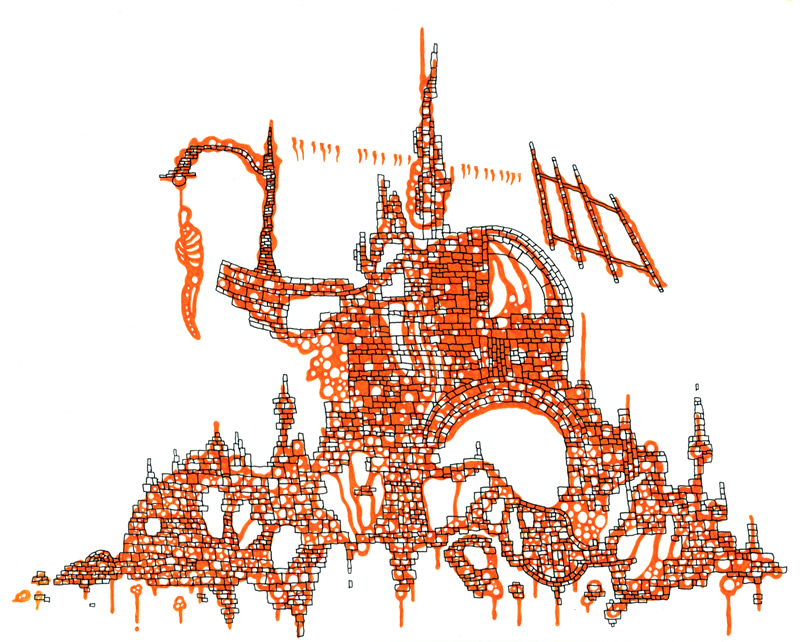

In [203]:
Image(filename='../../Images/IC_Zaira.jpg') 

### ZAIRA
        1. Reads an MCRD file produced by art/centella, which stores MCRD waveforms for PMTs (bins of 1 ns) and the SiPMs (bins of 1 mus)

        2. Simulates the response of the TRACKING plane (add gaussian and dark current noise), and produces SiPM RWF and store in output h5 file.
            
        3. Adds a table describing the SiPM FEE parameters used for simulation into the h5 output file.

        4. Monitor the input SiPM MCRD and output SiPM RFW.  

### Revision

author: Jose A. Hernando

version: v0_00

In [204]:
import time
print(time.strftime("%d/%m/%Y"),' ',time.strftime("%H:%M:%S"))

06/10/2016   23:31:24


### Dependencies

In [205]:
%matplotlib inline

In [206]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [207]:
%autoreload 2

In [208]:
import logging
import sys
logger = logging.getLogger()
#logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [209]:
pp = %env PYTHONPATH
print(pp)
from Util import *
from Configure import *
from Nh5 import *

/Users/hernando/Software/root/lib:/Users/hernando/Software/lib:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Core:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Config:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Sierpe


In [210]:
import tables
import pandas as pd
import time
import cProfile

In [211]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

### Inspecting the input file  

In [212]:
icdat = '/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/'
ifdat = 'nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5'
ofdat = 'zaira_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5'
h5f =tables.open_file(icdat+ifdat)

In [213]:
h5in =tables.open_file(icdat+ifdat)
h5in

File(filename=/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/pmtrd (EArray(1000, 12, 1200000), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/sipmrd (EArray(1000, 1789, 1200), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 1200)
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/MC (Group) ''
/MC/MCTrac

### check the SiPMs

#### inspecting the SiPM RD

In [214]:
# get the sipm table (all events)
sipmrd_ = h5in.root.sipmrd
nevts,nsipms,nshapes = sipmrd_.shape[0],sipmrd_.shape[1],sipmrd_.shape[2]
print(' nevents {}, nsipms {}, nshapes {}'.format(nevts,nsipms,nshapes))
    

 nevents 1000, nsipms 1789, nshapes 1200


slicing SiPM RD

In [215]:
# get the total charge vs ID per event
def sipms_qids(evt):
    """ returns the charge of the (ordered) sipms
    """
    sipm_evt = sipmrd_[evt]
    qids = map(lambda x: sum(x),sipm_evt)
    return qids

def sipms_qids_qfilter(qids,q0=0.):
    """ returns the ids of the SiPM with total charge above q0
    """
    ids = [id for id,q in enumerate(qids) if q>q0]
    return ids

def sipms_ids_wf_(evt,ids):
    """ returns the wf of the SiPMs of the list ids
    """
    wfs = map(lambda i: sipmrd_[evt,i],ids)
    return wfs

def sipms_id_indwf(evt,id,q0=0.):
    """ returns the index-w.f. a list of [(time,q),] for the selected SiPM with id in event evt
    """
    wf = sipmrd_[evt][id]
    indwf = [(i,q) for i,q in enumerate(wf) if q>q0]
    return indwf

def sipms_ids_indwf(evt,ids,q0=0.):
    """ returns the indexed wf (a list of [(time,q),] of the list of SiPMs with ids
    """
    indwfs = map(lambda id: sipms_id_indwf(evt,id,q0),ids)
    return indwfs

def sipms_indwfs_trange(indwfs):
    """ returns the trange of the indexed w.fs 
    """
    xs = []
    for indwf in indwfs:
        for iwf in indwf: xs.append(iwf[0])
    trange = range(min(xs),max(xs)+1)
    return trange


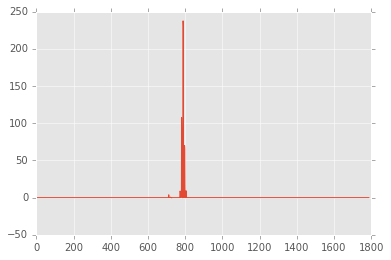

In [216]:
ievt = 15
qids = sipms_qids(ievt)
plt.plot(qids)

In [217]:
ids = sipms_qids_qfilter(qids,0.)
print('ids with q>10 {} '.format(ids))

### indexed w.f. of the selected SiPMs
indwfs = sipms_ids_indwf(ievt,ids,0)

trange = sipms_indwfs_trange(indwfs)
print('trange {}'.format(trange))

ids with q>10 [712, 720, 772, 773, 774, 775, 779, 780, 781, 782, 783, 788, 789, 790, 791, 795, 796, 797, 798, 799, 805, 806] 
trange [844, 845, 846, 847, 848, 849, 850, 851, 852, 853]


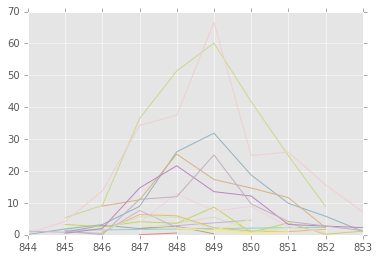

In [218]:
### list of colors to display
colors = plt.cm.Set3(np.linspace(0., 1., len(ids)))

### display the indexed w.fs
for i,indwf in enumerate(indwfs):
    xs = map(lambda x: x[0],indwf)
    ys = map(lambda x: x[1],indwf)
    plt.plot(xs,ys,color=colors[i])

#### Inspecting the x,y position of SiPM RD

In [219]:
# DB position of the (ordered) SiPMs 
sipmdb_ = h5in.root.Sensors.DataSiPM
print(sipmdb_[0])

def sipmdb_pos(i): return sipmdb_[i][2]

(1000, 1, [-235.0, 45.0, -10000.0], 1.0, 15.5)


In [220]:
# convert a list of charge ordered SiPMs into x,y display

def sipms_qids_xyq(qids):
    """ return a list with the (x,y,q) values from a list of the charge of the (ordered) SiPMs
    """
    val = []
    for i in range(nsipms):
        x,y,z = sipmdb_pos(i)
        q = qids[i]
        val.append([x,y,q])
    return val

def sipms_plot_qids_xyq(qids):
    """ return the plot (x,y,q) of alist of charge (ordered) SiPMs
    """
    vals = sipms_qids_xyq(qids)
    xs = map(lambda i: vals[i][0],range(nsipms))
    ys = map(lambda i: vals[i][1],range(nsipms))
    zs = map(lambda i: vals[i][2],range(nsipms))
    xmin,xmax = min(xs),max(xs)
    #print('xmin {} xmax {}'.format(xmin,xmax))
    n = int(xmax-xmin)
    xi = np.linspace(xmin-0.5,xmax+0.5,n)
    yi = np.linspace(xmin-0.5,xmax+0.5,n)

    from matplotlib.mlab import griddata
    zi = griddata(xs, ys, zs, xi, yi,interp='linear')
    ci = plt.contourf(xi, yi, zi)
    plt.colorbar()
    return ci

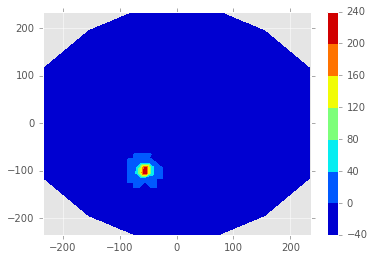

In [221]:
ci = sipms_plot_qids_xyq(qids)

In [222]:
def sipms_qids_tslice(evt,islice):
    """ returns a list with the charge of the SiPMs in the slice (islice)
    """
    qs = map(lambda i: sipmrd_[evt,i,islice], range(nsipms))
    return qs

division 10 3 4
t-slice 844 q-total 1.58231048658
t-slice 845 q-total 18.6028822064
t-slice 846 q-total 45.3104794659
t-slice 847 q-total 152.986546967
t-slice 848 q-total 210.71098575
t-slice 849 q-total 246.942376509
t-slice 850 q-total 144.957279213
t-slice 851 q-total 90.3487307429
t-slice 852 q-total 37.6443425994
t-slice 853 q-total 12.4168545604


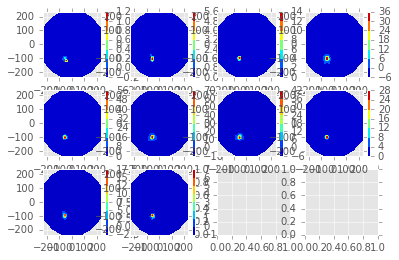

In [223]:
n = len(trange)
nx = int(sqrt(n))
ny=nx
if (nx*ny!=n):ny=ny+1
plt.subplots(nx,ny)
print('division {} {} {}'.format(n,nx,ny))
for i,islice in enumerate(trange):
    qs = sipms_qids_tslice(ievt,islice)
    print('t-slice {} q-total {}'.format(islice,sum(qs)))
    plt.subplot(nx,ny,i+1)
    sipms_plot_qids_xyq(qs)
    #plt.show()
    #q = raw_input('Enter key to continue')
    #if (q=='n'): continue
plt.show()

## SiPM FE 

In [224]:
from scipy.stats import norm,poisson

class FESiPMs:
    
    def __init__(self,nsipms=1792,nsamples=1200,tsample=1.,fname='../../Config/DB_FESiPMs_161006.txt'):
        # tsample units is us!
        fi = open(fname)
        lines = fi.readlines()
        print(' lines {}'.format(len(lines)))
        #self.fe = [(0.1,0.0324*tsample)]*nsipms 
        self.fe = [(0.,0.)]*nsipms
        self.indexes = []
        for i,line in enumerate(lines[1:]):
            words = line.split()
            if (len(words)!=3): print('words {}'.format(words))
            id,gaus,dark = int(words[0]),float(words[1]),float(words[2])
            iboard = int(id/1000)
            isipms = int(id%1000)
            index = int((iboard-1)*64+isipms)
            #print(' i {} id {} idx {} nois {} dark {} '.format(i,id,index,gaus,dark))
            self.fe[index] =(gaus,dark*tsample)
            self.indexes.append(index)
        fi.close()
        print('FESiPMs loaded # SiPMs {}'.format(len(self.fe)))
        #print(' fe {} '.format(self.fe))
        self.nsamples = nsamples
        self.tsample = tsample
        return
        
    def noise(self,i):
        gaus,pois = self.fe[i]
        ng = norm(0.,gaus).rvs(self.nsamples)
        np = poisson(pois).rvs(self.nsamples)
        return ng+np

 lines 1706
FESiPMs loaded # SiPMs 1792
len 1792


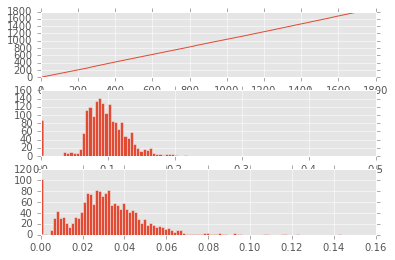

In [225]:
sipms_fe = FESiPMs()

fig,(ax0,ax1,ax2) = plt.subplots(3,1)
print('len {}'.format(len(sipms_fe.fe)))
ids = sipms_fe.indexes
ax0.plot(ids)
nois = map(lambda i: sipms_fe.fe[i][0],range(nsipms))
ax1.hist(nois,100)
dark = map(lambda i: sipms_fe.fe[i][1],range(nsipms))
ax2.hist(dark,100)
fig.show()


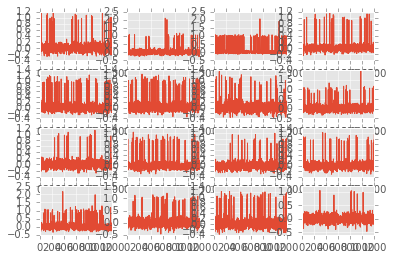

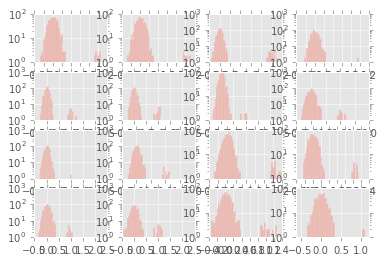

In [226]:
nx,ny=4,4
plt.subplots(nx,ny)

iboard = 1
for i in range(nx*ny):
    index = iboard*64+i
    wf = sipms_fe.noise(index)
    plt.subplot(nx,ny,i+1)
    plt.plot(wf)
plt.show()

plt.subplots(nx,ny)
for i in range(nx*ny):
    index = iboard*64+i
    wf = sipms_fe.noise(index)
    plt.subplot(nx,ny,i+1)
    plt.hist(wf,100,log=True)
plt.show()

### Script in IC/Cities/ZAIRA.py

In [227]:
#------


"""

ZAIRA
ChangeLog:

06.10 
"""


def ZAIRA(argv):
    """
    Diomira driver
    """
    DEBUG_LEVEL, INFO, CYTHON, CFP = configure(argv[0],argv[1:])
   
    if INFO:
        
        print("""
        ZAIRA:
        1. Reads an MCRD file produced by art/centella, which stores MCRD 
         waveforms for PMTs (bins of 1 ns) and the SiPMs (bins of 1 mus)
           
        2. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        """)
        
    PATH_IN =CFP['PATH_IN']
    PATH_OUT =CFP['PATH_OUT']
    FILE_IN =CFP['FILE_IN']
    FILE_OUT =CFP['FILE_OUT']
    FIRST_EVT =CFP['FIRST_EVT']
    LAST_EVT =CFP['LAST_EVT']
    RUN_ALL =CFP['RUN_ALL']
    CLIB =CFP['CLIB']
    CLEVEL =CFP['CLEVEL']
    NEVENTS = LAST_EVT - FIRST_EVT

    print('Debug level = {}'.format(DEBUG_LEVEL))

    print("input path ={}; output path = {}; file_in ={} file_out ={}".format(
        PATH_IN,PATH_OUT,FILE_IN, FILE_OUT))

    print("first event = {} last event = {} nof events requested = {} ".format(
        FIRST_EVT,LAST_EVT,NEVENTS))

    print("Compression library = {} Compression level = {} ".format(
        CLIB,CLEVEL))

    # open the input file 
    with tables.open_file("{}/{}".format(PATH_IN,FILE_IN), "r+") as h5in: 
        # access the PMT raw data in file 

        sipmrd_ = h5in.root.sipmrd

        #pmtrd_.shape = (nof_events, nof_sensors, wf_length)

        NSIPM = sipmrd_.shape[1]
        SIPMWL = sipmrd_.shape[2]
        NEVENTS_DST = pmtrd_.shape[0]

        #access the geometry and the sensors metadata info
        sipm_t = h5in.root.Sensors.DataSiPM
        
        #LOOP
        print('running events first {} last {}'.format(FIRST_EVT,LAST_EVT))
        first_evt, last_evt = define_event_loop(FIRST_EVT,LAST_EVT,NEVENTS,NEVENTS_DST,RUN_ALL)
            
        for i in range(first_evt,last_evt):
            logger.info("-->event number ={}".format(i))

        print("Leaving Zaira. Safe travels!")


### Input file

In [228]:
icdat = '/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/'
ifdat = 'nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5'
ofdat = 'zaira_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5'

### Configuration file

In [229]:
%less ../../Config/ZAIRA_dev.csv

### Running the script

In [230]:
%time ZAIRA(['ZAIRA','-i','-d','INFO','-c''../../Config/ZAIRA_dev.csv'])


        ZAIRA:
        1. Reads an MCRD file produced by art/centella, which stores MCRD 
         waveforms for PMTs (bins of 1 ns) and the SiPMs (bins of 1 mus)
           
        2. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        
Debug level = INFO
input path =/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/; output path = /Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/; file_in =nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5 file_out =diomira_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5
first event = 0 last event = 10 nof events requested = 10 
Compression library = zlib Compression level = 1 


HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 604, in H5Fopen
    unable to open file
  File "H5Fint.c", line 1028, in H5F_open
    file is already open for read-only

End of HDF5 error back trace

Unable to open/create file '/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data//nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5'

### Checking the output file

In [231]:
%ls -lh icdat+ofdat

ls: icdat+ofdat: No such file or directory


In [232]:
h5f =tables.open_file(icdat+ofdat)

IOError: ``/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/zaira_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5`` does not exist